In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import cartopy.crs as ccrs
import xarray as xr
import cmocean.cm as cmocean
import glob
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.path as mpath
import matplotlib.colors as col
from netCDF4 import Dataset


import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

figdir = '/g/data/e14/pc5520/figures/basal_melt_param/'

In [2]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 5
Total threads: 20,Total memory: 128.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35405,Workers: 5
Dashboard: /proxy/8787/status,Total threads: 20
Started: Just now,Total memory: 128.00 GiB
Comm: tcp://127.0.0.1:46611,Total threads: 4
Dashboard: /proxy/36175/status,Memory: 25.60 GiB
Nanny: tcp://127.0.0.1:33409,


In [3]:
# database for control simulation:
master_session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
control = '01deg_jra55v13_ryf9091'

# database for perturbations:
basal_session = cc.database.create_session('/g/data/v45/akm157/model_data/access-om2/01deg_jra55v13_ryf9091_easterlies_up10/easterlies.db')
# 10% increase in easterly wind speed:
easterlies_up = '01deg_jra55v13_ryf9091_easterlies_up10'
# 10% decrease in easterly wind speed:
easterlies_down = '01deg_jra55v13_ryf9091_easterlies_down10'

In [4]:
master_session = cc.database.create_session()

control = '01deg_jra55v13_ryf9091'


# realistic calving + conservative temperature + tfreezing as in GPC006 / calving put in runoff array - test
Tfreezing_min_calv_2 = 'accessom2-GPC013'
# idem as GPC013 but gade line formulation
Tfreezing_min_calv_2_gade = 'accessom2-GPC015'

start_time='2152-01-01'
end_time='2153-01-01'

lat_slice  = slice(-80,-59)

In [5]:
# build database for these experiments:
session_name = '/g/data/e14/pc5520/model_data/access-om2/basal_melt_MOM5/basal_melt_MOM5.db'
basal_melt_session = cc.database.create_session(session_name)

dir_list = ['/g/data/e14/pc5520/access-om2/archive/01deg_jra55v13_ryf9091_rerun_for_easterlies/accessom2-GPC013/',
           '/g/data/ik11/outputs/access-om2-01/basal_melt_outputs/accessom2-GPC015/accessom2-GPC015/']
cc.database.build_index(dir_list,basal_melt_session)

Indexing experiment: accessom2-GPC013


0it [00:00, ?it/s]


Indexing experiment: accessom2-GPC015


0it [00:00, ?it/s]


0

In [6]:
# topography data for plotting:
ht = cc.querying.getvar(control,'ht' , master_session,n=1).sel(yt_ocean=lat_slice)
land_mask = np.squeeze(ht.values)*0
land_mask[np.isnan(land_mask)] = 1
land_mask = np.where(land_mask==1,land_mask,np.nan)
land_mask_masked = np.ma.masked_where((land_mask==0),land_mask)
# make land go all the way to -90S:
land_mask_lat = ht.yt_ocean.values
land_mask_lat[0] = -90

fontsize=15

In [7]:
###Check runoff flux
#Import runoff
runoff_con = cc.querying.getvar(control, 'runoff', master_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
runoff_con = runoff_con.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
runoff_con = runoff_con.sum('yt_ocean').sum('xt_ocean').load()

runoff_Tfreezing_min_calv_2 = cc.querying.getvar(Tfreezing_min_calv_2, 'runoff', basal_melt_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
runoff_Tfreezing_min_calv_2 = runoff_Tfreezing_min_calv_2.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
runoff_Tfreezing_min_calv_2 = runoff_Tfreezing_min_calv_2.sum('yt_ocean').sum('xt_ocean').load()

In [8]:
river_Tfreezing_min_calv_2 = cc.querying.getvar(Tfreezing_min_calv_2, 'river', basal_melt_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
river_Tfreezing_min_calv_2 = river_Tfreezing_min_calv_2.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
river_Tfreezing_min_calv_2 = river_Tfreezing_min_calv_2.sum('yt_ocean').sum('xt_ocean').load()

#Import basal melt
basal_Tfreezing_min_calv_2 = cc.querying.getvar(Tfreezing_min_calv_2, 'basal_fwflx', basal_melt_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
basal_Tfreezing_min_calv_2 = basal_Tfreezing_min_calv_2.sel(time=slice(start_time,end_time))
basal_Tfreezing_min_calv_2 = basal_Tfreezing_min_calv_2[:,:,:,:].sum('yt_ocean_sub01').sum('xt_ocean_sub01').sum('st_ocean').load()

basal_Tfreezing_min_2d_calv_2 = cc.querying.getvar(Tfreezing_min_calv_2, 'basal_fwflx2d', basal_melt_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
basal_Tfreezing_min_2d_calv_2 = basal_Tfreezing_min_2d_calv_2.sel(time=slice(start_time,end_time))
basal_Tfreezing_min_2d_calv_2 = basal_Tfreezing_min_2d_calv_2.sum('yt_ocean_sub01').sum('xt_ocean_sub01').load()

calving_Tfreezing_min_2d_calv_2 = river_Tfreezing_min_calv2

tot_fwflux_calv_2 = river_Tfreezing_min_calv2 + basal_Tfreezing_min_calv_2

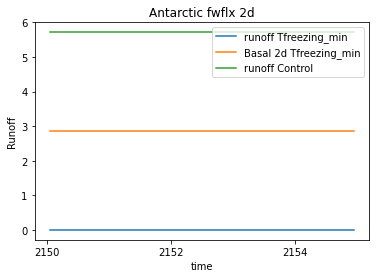

In [11]:
runoff_Tfreezing_min.plot(label='runoff Tfreezing_min')
basal_Tfreezing_min_2d.plot(label='Basal 2d Tfreezing_min')
runoff_con.plot(label='runoff Control')
plt.title('Antarctic fwflx 2d')
plt.ylabel('Runoff')
plt.legend();

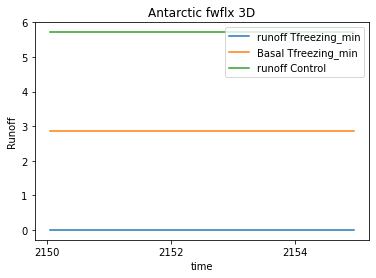

In [12]:
#runoff_Tfreezing_insituS.plot(label='Tfreezing_insituS')
#runoff_Tfreezing_zeroS.plot(label='Tfreezing_zeroS')
runoff_Tfreezing_min.plot(label='runoff Tfreezing_min')
basal_Tfreezing_min.plot(label='Basal Tfreezing_min')
runoff_con.plot(label='runoff Control')
plt.title('Antarctic fwflx 3D')
plt.ylabel('Runoff')
plt.legend();

Text(0.5, 1.0, 'Basal Tfreezing_min / runoff Control')

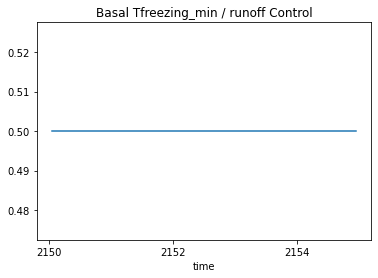

In [13]:
(basal_Tfreezing_min/runoff_con).plot(label='Basal Tfreezing_min / runoff Control')
plt.title('Basal Tfreezing_min / runoff Control')

Text(0.5, 1.0, 'River Tfreezing_min / runoff Control')

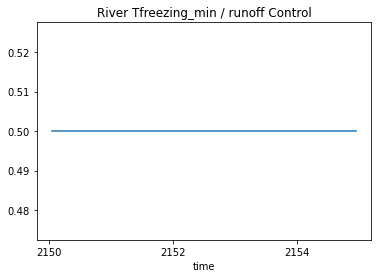

In [14]:
(river_Tfreezing_min/runoff_con).plot(label='River Tfreezing_min / runoff Control')
plt.title('River Tfreezing_min / runoff Control')

In [25]:
# Check the ratio betwee basal and runoff on the x dimension

#Import runoff
runoff_con_x = cc.querying.getvar(control, 'runoff', master_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
runoff_con_x = runoff_con_x.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
runoff_con_x = runoff_con_x.sum('yt_ocean').load()

#Import basal melt
basal_Tfreezing_min_x = cc.querying.getvar(Tfreezing_min, 'basal_fwflx', basal_melt_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
basal_Tfreezing_min_x = basal_Tfreezing_min_x.sel(time=slice(start_time,end_time))
basal_Tfreezing_min_x = basal_Tfreezing_min_x[:,:,:,:].sum('yt_ocean').sum('st_ocean').load()

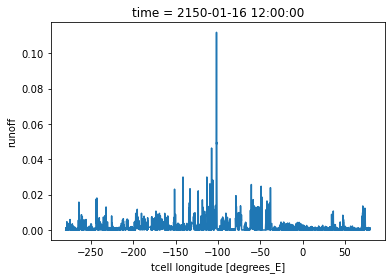

In [27]:
runoff_con_x[0].plot()

In [16]:
ratio_x = basal_Tfreezing_min_x * 0
for nt in range(basal_Tfreezing_min_x.shape[0]):
    for nx in range(basal_Tfreezing_min_x.shape[1]):
        if runoff_con_x[nt,nx] != 0:
            ratio_x[nt,nx] = basal_Tfreezing_min_x[nt,nx]/runoff_con_x[nt,nx]/0.5
        if basal_Tfreezing_min_x[nt,nx] == 0 and runoff_con_x[nt,nx] == 0: 
            ratio_x[nt,nx]=1


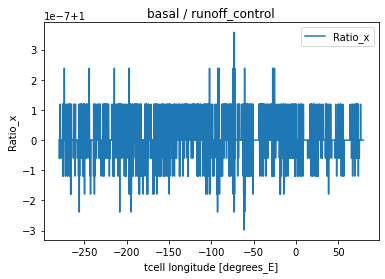

In [17]:
ratio_x[-1,:].plot(label='Ratio_x')
plt.title('basal / runoff_control')
plt.ylabel('Ratio_x')
plt.legend();

In [18]:
# Timeseries of depth integrated salinity on shelf:

In [7]:
# shelf masking:
contour_file = np.load('/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz')
shelf_mask = contour_file['contour_masked_above']
yt_ocean = contour_file['yt_ocean']
xt_ocean = contour_file['xt_ocean']
# Mask values that are non-zero
shelf_mask[np.where(shelf_mask!=0)] = np.nan
shelf_mask = shelf_mask+1
shelf_map = np.nan_to_num(shelf_mask)
shelf_mask = xr.DataArray(shelf_mask, coords = [('yt_ocean', yt_ocean), ('xt_ocean', xt_ocean)])
# Multiply the variable with the mask, we need to account for the shape of the mask. 
# The mask uses a northern cutoff of 59S.
shelf_mask = shelf_mask.sel(yt_ocean=lat_slice)

In [8]:
# thickness area for depth averaging (not time varying):

temp_con = cc.querying.getvar(control,'temp' , master_session,frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
temp_con = temp_con.sel(yt_ocean=lat_slice).sel(time=slice(start_time,end_time))
# import edges of st_ocean and add lat/lon dimensions:
st_edges_ocean = cc.querying.getvar(control, 'st_edges_ocean', master_session, start_time=start_time, end_time=end_time, n=1)
st_edges_array = st_edges_ocean.expand_dims({'yt_ocean':temp_con.yt_ocean,'xt_ocean':temp_con.xt_ocean}, axis=[1,2])

# adjust edges at bottom for partial thickness:
ht = cc.querying.getvar(control,'ht' , master_session,n=1).sel(yt_ocean=lat_slice)
st_edges_with_partial = st_edges_array.where(st_edges_array<ht, other=ht)
thickness = st_edges_with_partial.diff(dim='st_edges_ocean')

# change coordinate of thickness to st_ocean (needed for multipling with other variables):
st_ocean = cc.querying.getvar(control, 'st_ocean', master_session, n=1)
thickness['st_edges_ocean'] = st_ocean.values
thickness = thickness.rename(({'st_edges_ocean':'st_ocean'}))

In [9]:
# area for area averaging:

area_t = cc.querying.getvar(control,'area_t',master_session, ncfile = 'ocean_grid.nc',n=-1)
area_t = area_t.sel(yt_ocean=lat_slice)
area_t = area_t * shelf_mask

#area_sum = area_t.sum('xt_ocean').sum('yt_ocean')

volume = area_t*thickness
volume_sum = volume.sum()

In [13]:
start_time='2150-01-01'
end_time='2160-01-01'

salt_con = cc.querying.getvar(control, 'salt', master_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
salt_con = salt_con.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
# shelf masking:
salt_con = salt_con*shelf_mask
# area and depth averaging on the shelf:
salt_con = (salt_con*volume).sum('xt_ocean').sum('yt_ocean').sum('st_ocean')/volume_sum
salt_con = salt_con.load()

In [14]:
salt_Tfreezing_min_calv_2_gade = cc.querying.getvar(Tfreezing_min_calv_2_gade, 'salt', basal_melt_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
salt_Tfreezing_min_calv_2_gade = salt_Tfreezing_min_calv_2_gade.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
# shelf masking:
salt_Tfreezing_min_calv_2_gade = salt_Tfreezing_min_calv_2_gade*shelf_mask
# area and depth averaging on the shelf:
salt_Tfreezing_min_calv_2_gade = (salt_Tfreezing_min_calv_2_gade*volume).sum('xt_ocean').sum('yt_ocean').sum('st_ocean')/volume_sum
salt_Tfreezing_min_calv_2_gade = salt_Tfreezing_min_calv_2_gade.load()

Text(0.5, 1.0, 'Depth average salinity on the shelf')

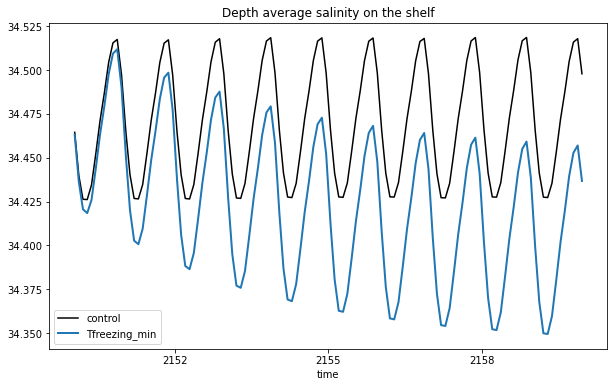

In [15]:
plt.figure(figsize=(10,6))

salt_con.plot(label='control',color='k')
salt_Tfreezing_min_calv_2_gade.plot(label='Tfreezing_min',linewidth=2)
plt.legend()
plt.title('Depth average salinity on the shelf')

In [10]:
start_time='2150-01-01'
end_time='2160-01-01'
temp_con = cc.querying.getvar(control, 'temp', master_session, frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
temp_con = temp_con.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
# shelf masking:
temp_con = temp_con*shelf_mask
# area and depth averaging on the shelf:
temp_con = (temp_con*volume).sum('xt_ocean').sum('yt_ocean').sum('st_ocean')/volume_sum
temp_con = temp_con.load()

temp_Tfreezing_min_calv_2_gade = cc.querying.getvar(Tfreezing_min_calv_2_gade, 'temp', basal_melt_session, frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
temp_Tfreezing_min_calv_2_gade = temp_Tfreezing_min_calv_2_gade.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
# shelf masking:
temp_Tfreezing_min_calv_2_gade = temp_Tfreezing_min_calv_2_gade*shelf_mask
# area and depth averaging on the shelf:
temp_Tfreezing_min_calv_2_gade = (temp_Tfreezing_min_calv_2_gade*volume).sum('xt_ocean').sum('yt_ocean').sum('st_ocean')/volume_sum
temp_Tfreezing_min_calv_2_gade = temp_Tfreezing_min_calv_2_gade.load()

#temp_Tfreezing_min_calv_2 = cc.querying.getvar(Tfreezing_min_calv_2, 'temp', basal_melt_session, frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
#temp_Tfreezing_min_calv_2 = temp_Tfreezing_min_calv_2.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
# shelf masking:
#temp_Tfreezing_min_calv_2 = temp_Tfreezing_min_calv_2*shelf_mask
# area and depth averaging on the shelf:
#temp_Tfreezing_min_calv_2 = (temp_Tfreezing_min_calv_2*volume).sum('xt_ocean').sum('yt_ocean').sum('st_ocean')/volume_sum
#temp_Tfreezing_min_calv_2 = temp_Tfreezing_min_calv_2.load()

Text(0.5, 1.0, 'Depth average temperature on the shelf')

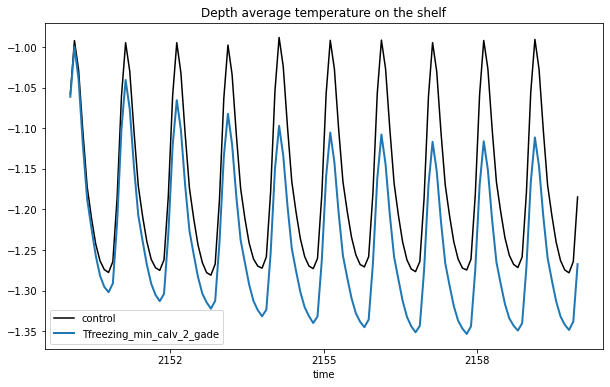

In [11]:
plt.figure(figsize=(10,6))

temp_con.plot(label='control',color='k')
#temp_Tfreezing_min_calv_2.plot(label='Tfreezing_min_calv_2',linewidth=0.5)
temp_Tfreezing_min_calv_2_gade.plot(label='Tfreezing_min_calv_2_gade',linewidth=2)
plt.legend()
plt.title('Depth average temperature on the shelf')

In [16]:
# Tbasal

In [17]:
temp_Tfreezing_min = cc.querying.getvar(Tfreezing_min, 'temp_basal', basal_melt_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
temp_Tfreezing_min = temp_Tfreezing_min.sel(time=slice(start_time,end_time))
temp_Tfreezing_min_avet = temp_Tfreezing_min.min('yt_ocean_sub01').mean('time').load()

temp_Tfreezing_min_calv_2 = cc.querying.getvar(Tfreezing_min_calv_2, 'temp_basal', basal_melt_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
temp_Tfreezing_min_calv_2 = temp_Tfreezing_min_calv_2.sel(time=slice(start_time,end_time))
temp_Tfreezing_min_calv_2_avet = temp_Tfreezing_min_calv_2.min('yt_ocean_sub01').mean('time').load()

2022-10-19 20:12:40,874 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/dask/array/reductions.py:579: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(x_chunk, axis=axis, keepdims=keepdims)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/dask/array/reductions.py:579: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(x_chunk, axis=axis, keepdims=keepdims)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/dask/array/reductions.py:579: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(x_chunk, axis=axis, keepdims=keepdims)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/dask/array/reductions.py:579: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(x_chunk, axis=axis, keepdims=keepdims)
/g/data/hh5/pu

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


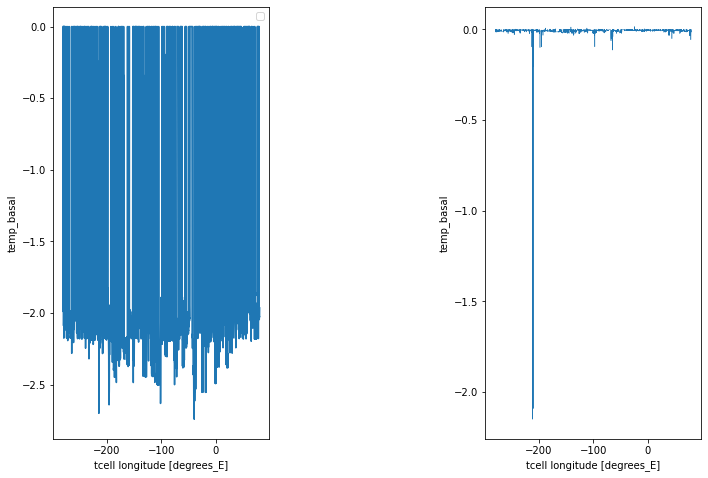

In [18]:
fig = plt.figure(figsize=(10,6))

ax = fig.add_axes([0.0, 0.0, 0.3, 1])
temp_Tfreezing_min_calv_2_avet.plot()
plt.legend()

ax = fig.add_axes([0.6, 0.0, 0.3, 1])
(temp_Tfreezing_min_avet-temp_Tfreezing_min_calv_2_avet).plot(linewidth=0.5)
#plt.legend()

In [ ]:
plt.figure(figsize=(10,6))

temp_con.plot(label='control',color='k')
#temp_Tfreezing_insituS.plot(label='Tfreezing_insituS',linewidth=2)
#temp_Tfreezing_zeroS.plot(label='Tfreezing_zeroS',linestyle='--')
temp_Tfreezing_min.plot(label='Tfreezing_min',linewidth=0.5)
temp_Tfreezing_min_calv_2.plot(label='Tfreezing_min_calv_2',linewidth=0.5)
plt.legend()
plt.title('Depth average temperature on the shelf')

In [7]:
# Heat flux from runoff

In [15]:
###Check runoff flux
#Import runoff
hflux_runoff_con = cc.querying.getvar(control, 'sfc_hflux_from_runoff', master_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
hflux_runoff_con = hflux_runoff_con.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
hflux_runoff_con_x = hflux_runoff_con.sum('yt_ocean').load()
hflux_runoff_con_x_avet = hflux_runoff_con.sum('yt_ocean')
hflux_runoff_con_x_avet = hflux_runoff_con_x_avet.mean('time').load()
hflux_runoff_con = hflux_runoff_con.sum('yt_ocean').sum('xt_ocean').load()

In [18]:
hflux_Tfreezing_min_calv_2_gade = cc.querying.getvar(Tfreezing_min_calv_2_gade, 'temp_basalmix', basal_melt_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
hflux_Tfreezing_min_calv_2_gade = hflux_Tfreezing_min_calv_2_gade.sel(time=slice(start_time,end_time))
hflux_Tfreezing_min_calv_2_gade_x = hflux_Tfreezing_min_calv_2_gade.sum('yt_ocean').sum('st_ocean')
hflux_Tfreezing_min_calv_2_gade_x_avet = hflux_Tfreezing_min_calv_2_gade_x.mean('time').load()
hflux_Tfreezing_min_calv_2_gade = hflux_Tfreezing_min_calv_2_gade_x.sum('xt_ocean').load()
hflux_Tfreezing_min_calv_2_gade_x = hflux_Tfreezing_min_calv_2_gade_x.load()

hflux_Tfreezing_min_calv_2 = cc.querying.getvar(Tfreezing_min_calv_2, 'temp_basalmix', basal_melt_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
hflux_Tfreezing_min_calv_2 = hflux_Tfreezing_min_calv_2.sel(time=slice(start_time,end_time))
hflux_Tfreezing_min_calv_2_x = hflux_Tfreezing_min_calv_2.sum('yt_ocean').sum('st_ocean')
hflux_Tfreezing_min_calv_2_x_avet = hflux_Tfreezing_min_calv_2_x.mean('time').load()
hflux_Tfreezing_min_calv_2 = hflux_Tfreezing_min_calv_2_x.sum('xt_ocean').load()
hflux_Tfreezing_min_calv_2_x = hflux_Tfreezing_min_calv_2_x.load()

2022-11-16 17:27:04,243 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2022-11-16 17:27:14,139 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2022-11-16 17:27:34,870 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2022-11-16 17:27:35,785 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2022-11-16 17:27:37,382 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2022-11-16 17:27:38,397 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2022-11-16 17:27:40,269 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2022-11-16 17:27:46,752 - distributed.utils_perf - WARNING - full garbage collections took

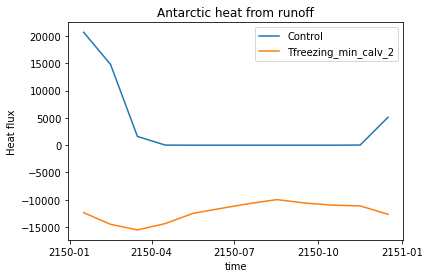

In [19]:
hflux_runoff_con.plot(label='Control')
hflux_Tfreezing_min_calv_2.plot(label='Tfreezing_min_calv_2')
#hflux_Tfreezing_min_calv_2_gade.plot(label='Tfreezing_min_calv_2_gade')
plt.title('Antarctic heat from runoff')
plt.ylabel('Heat flux')
plt.legend();

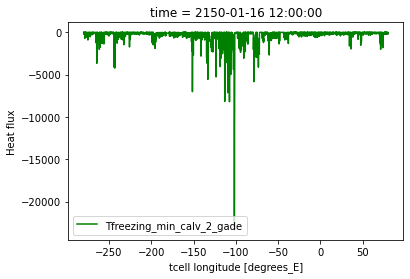

Exception during reset or similar
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/sqlalchemy/pool/base.py", line 697, in _finalize_fairy
    fairy._reset(pool)
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/sqlalchemy/pool/base.py", line 893, in _reset
    pool._dialect.do_rollback(self)
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/sqlalchemy/engine/default.py", line 558, in do_rollback
    dbapi_connection.rollback()
sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 23014577641280 and this is thread id 23011718256384.
Exception closing connection <sqlite3.Connection object at 0x14edc74f3210>
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/sqlalchemy/pool/b

In [21]:
hflux_Tfreezing_min_calv_2_gade_x.plot(label='Tfreezing_min_calv_2_gade',color='g')
plt.ylabel('Heat flux')
plt.legend();

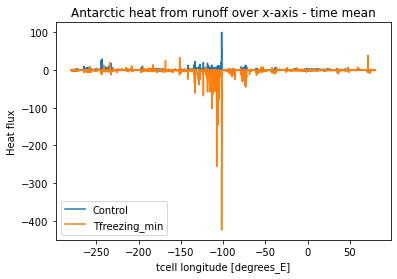

In [29]:
hflux_runoff_con_x_avet.plot(label='Control')
hflux_Tfreezing_min_x_avet.plot(label='Tfreezing_min')
#hflux_Tfreezing_min_calv_2_x_avet.plot(label='Tfreezing_min')
plt.title('Antarctic heat from runoff over x-axis - time mean')
plt.ylabel('Heat flux')
plt.legend();

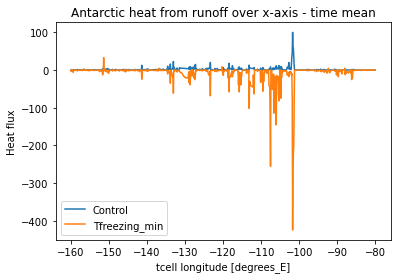

In [28]:
hflux_runoff_con_x_avet[1200:2000].plot(label='Control')
hflux_Tfreezing_min_x_avet[1200:2000].plot(label='Tfreezing_min')
plt.title('Antarctic heat from runoff over x-axis - time mean')
plt.ylabel('Heat flux')
plt.legend();

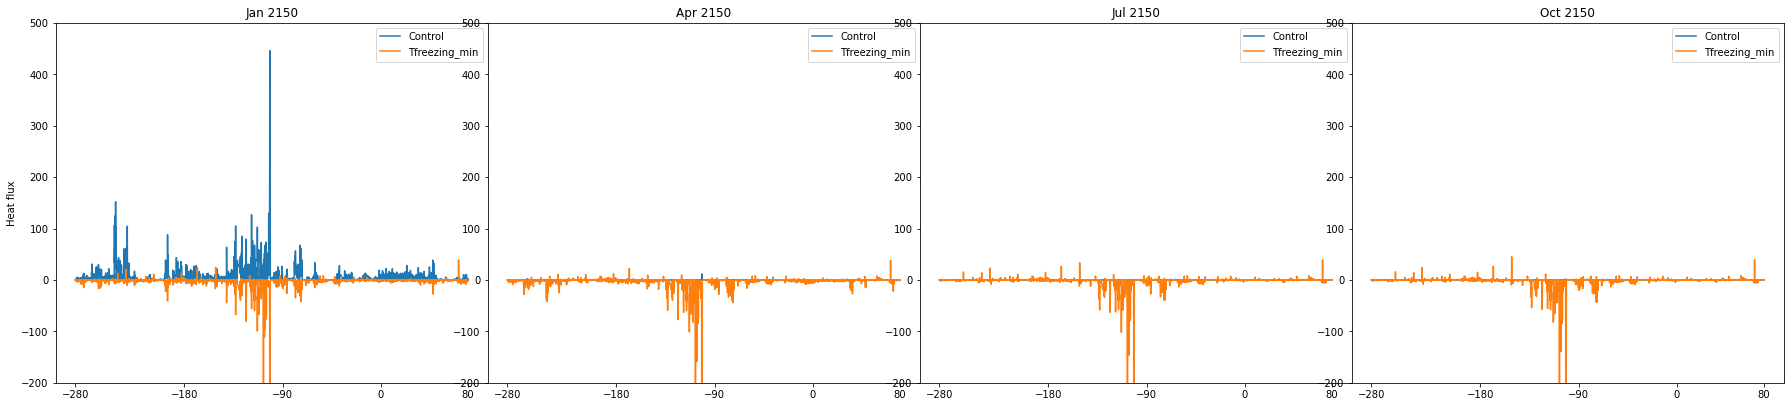

In [30]:
fig  = plt.figure(1, figsize = (20,5))

tt=0
ax = fig.add_axes([0.0, 0.0, 0.3, 1])
ax.plot(hflux_runoff_con_x['xt_ocean'],hflux_runoff_con_x[tt],label='Control')
ax.plot(hflux_runoff_con_x['xt_ocean'],hflux_Tfreezing_min_x[tt],label='Tfreezing_min')
plt.title('Jan 2150')
plt.ylabel('Heat flux')
plt.xticks([-280,-180,-90,0,80])
plt.yticks([-200,-100,0,100,200,300,400,500])
plt.ylim(-200,500)
plt.legend()

tt=3
ax = fig.add_axes([0.3, 0.0, 0.3, 1])
ax.plot(hflux_runoff_con_x['xt_ocean'],hflux_runoff_con_x[tt],label='Control')
ax.plot(hflux_runoff_con_x['xt_ocean'],hflux_Tfreezing_min_x[tt],label='Tfreezing_min')
plt.title('Apr 2150')
#plt.ylabel('Heat flux')
plt.xticks([-280,-180,-90,0,80])
plt.yticks([-200,-100,0,100,200,300,400,500])
plt.ylim(-200,500)
plt.legend()

tt=6
ax = fig.add_axes([0.6, 0.0, 0.3, 1])
ax.plot(hflux_runoff_con_x['xt_ocean'],hflux_runoff_con_x[tt],label='Control')
ax.plot(hflux_runoff_con_x['xt_ocean'],hflux_Tfreezing_min_x[tt],label='Tfreezing_min')
plt.title('Jul 2150')
#plt.ylabel('Heat flux')
plt.xticks([-280,-180,-90,0,80])
plt.yticks([-200,-100,0,100,200,300,400,500])
plt.ylim(-200,500)
plt.legend()

tt=9
ax = fig.add_axes([0.9, 0.0, 0.3, 1])
ax.plot(hflux_runoff_con_x['xt_ocean'],hflux_runoff_con_x[tt],label='Control')
ax.plot(hflux_runoff_con_x['xt_ocean'],hflux_Tfreezing_min_x[tt],label='Tfreezing_min')
plt.title('Oct 2150')
#plt.ylabel('Heat flux')
plt.xticks([-280,-180,-90,0,80])
plt.yticks([-200,-100,0,100,200,300,400,500])
plt.ylim(-200,500)
plt.legend()

In [40]:
# Bottom analysis

## Temp

In [7]:
start_time='2169-01-01'
end_time='2170-01-01'

temp_con = cc.querying.getvar(control, 'temp', master_session, frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
temp_con = temp_con.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
temp_con = temp_con.mean('time')

temp_Tfreezing_min_calv_2_gade = cc.querying.getvar(Tfreezing_min_calv_2_gade, 'temp', basal_melt_session, frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
temp_Tfreezing_min_calv_2_gade = temp_Tfreezing_min_calv_2_gade.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
temp_Tfreezing_min_calv_2_gade = temp_Tfreezing_min_calv_2_gade.mean('time')

#temp_Tfreezing_min_calv_2 = cc.querying.getvar(Tfreezing_min_calv_2, 'temp', basal_melt_session, frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
#temp_Tfreezing_min_calv_2 = temp_Tfreezing_min_calv_2.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
#temp_Tfreezing_min_calv_2 = temp_Tfreezing_min_calv_2.mean('time')

In [8]:
# select out bottom values:

depth_array = temp_con * 0 + temp_con.st_ocean
max_depth = depth_array.max(dim = 'st_ocean', skipna= True)

bottom_temp_con = temp_con.where(depth_array.st_ocean >= max_depth)
bottom_temp_con = bottom_temp_con.sum(dim = 'st_ocean')
bottom_temp_con = bottom_temp_con.load()

bottom_temp_Tfreezing_min_calv_2_gade = temp_Tfreezing_min_calv_2_gade.where(depth_array.st_ocean >= max_depth)
bottom_temp_Tfreezing_min_calv_2_gade = bottom_temp_Tfreezing_min_calv_2_gade.sum(dim = 'st_ocean')
bottom_temp_Tfreezing_min_calv_2_gade = bottom_temp_Tfreezing_min_calv_2_gade.load()

#bottom_temp_Tfreezing_min_calv_2 = temp_Tfreezing_min_calv_2.where(depth_array.st_ocean >= max_depth)
#bottom_temp_Tfreezing_min_calv_2 = bottom_temp_Tfreezing_min_calv_2.sum(dim = 'st_ocean')
#bottom_temp_Tfreezing_min_calv_2 = bottom_temp_Tfreezing_min_calv_2.load()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice 

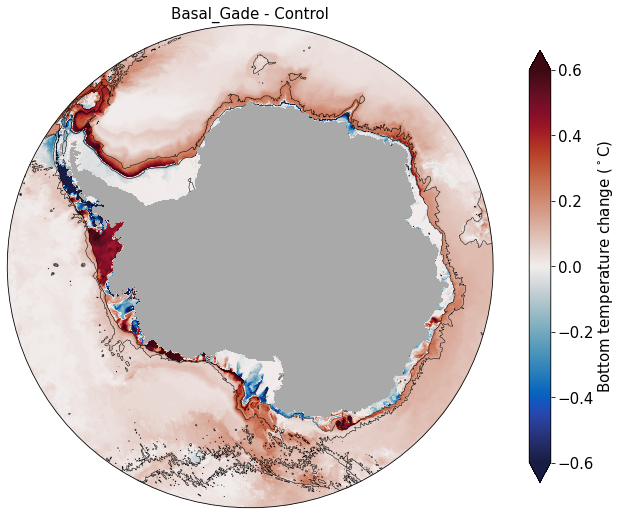

In [10]:
scale_max = .6

fig  = plt.figure(1, figsize = (25,12))
norm = col.Normalize(vmin=-scale_max,vmax=scale_max)
norm2 = col.Normalize(vmin=-2.4,vmax=1.5)

# Gade
# setup stereo projection:
#ax = fig.add_axes([0.0, 0.0, 0.27, 1],projection=ccrs.SouthPolarStereo())
#theta = np.linspace(0, 2*np.pi, 100)
#center, radius = [0.5, 0.5], 0.5
#verts = np.vstack([np.sin(theta), np.cos(theta)]).T
#circle = mpath.Path(verts * radius + center)
#ax.set_boundary(circle, transform=ax.transAxes)
## plot:
#vmin,vmax,contourstep=-2.4,1.7,0.2
##nb_contours = np.ceil((vmax-vmin)/contourstep)
#nb_contours = 20
##contours = np.arange(vmin,vmax+contourstep,contourstep)
#contours = [round(x , 4) for x in np.linspace(vmin,vmax,int(nb_contours+1))]
#cf1 = ax.pcolormesh(bottom_temp_con.xt_ocean, bottom_temp_con.yt_ocean, bottom_temp_Tfreezing_min_calv_2 - bottom_temp_con,
#                   norm=norm,cmap = cmocean.balance, transform = ccrs.PlateCarree())
#ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
#plt.title('Basal_Heat_Balance - Control',fontsize=fontsize)
#ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',
#             zorder=2,transform = ccrs.PlateCarree())
#ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())

# Anomaly Tfreezing_min_calv_2
# setup stereo projection:
ax = fig.add_axes([0, 0.0, 0.27, 1],projection=ccrs.SouthPolarStereo())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
# plot:
vmin,vmax,contourstep=-2.4,1.7,0.2
#nb_contours = np.ceil((vmax-vmin)/contourstep)
nb_contours = 20
#contours = np.arange(vmin,vmax+contourstep,contourstep)
contours = [round(x , 4) for x in np.linspace(vmin,vmax,int(nb_contours+1))]
cf = ax.pcolormesh(bottom_temp_con.xt_ocean, bottom_temp_con.yt_ocean, bottom_temp_Tfreezing_min_calv_2_gade - bottom_temp_con,
                   norm=norm,cmap = cmocean.balance, transform = ccrs.PlateCarree())
ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
plt.title('Basal_Gade - Control',fontsize=fontsize)
ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',
             zorder=2,transform = ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())

# colorbar:
#cbaxes = fig.add_axes([0.56, 0.25, 0.012, 0.5])
#cbar = plt.colorbar(cf1, ticks=[-2,-1,0,1],cax = cbaxes, orientation = 'vertical',extend = 'both')
#cbar.set_label(r'Basal_heat_balance - Control',fontsize=fontsize,labelpad=2)
#cbar.ax.tick_params(labelsize=fontsize)

# Anomaly Gade
#ax = fig.add_axes([0.62, 0.0, 0.27, 1],projection=ccrs.SouthPolarStereo())
#theta = np.linspace(0, 2*np.pi, 100)
#center, radius = [0.5, 0.5], 0.5
#verts = np.vstack([np.sin(theta), np.cos(theta)]).T
#circle = mpath.Path(verts * radius + center)
#ax.set_boundary(circle, transform=ax.transAxes)
## plot:
#cf = ax.pcolormesh(bottom_temp_con.xt_ocean, bottom_temp_con.yt_ocean, bottom_temp_Tfreezing_min_calv_2_gade-bottom_temp_Tfreezing_min_calv_2,
#                    norm=norm,cmap = cmocean.balance, transform = ccrs.PlateCarree())
#ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
#plt.title('Basal_Gade - Basal_Heat_Balance',fontsize=fontsize)
#ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',
#             zorder=2,transform = ccrs.PlateCarree())
#ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())

# colorbar:
cbaxes = fig.add_axes([0.29, 0.25, 0.012, 0.5])
cbar = plt.colorbar(cf, cax = cbaxes, orientation = 'vertical',extend = 'both')
cbar.set_label(r'Bottom temperature change ($^\circ$C)',fontsize=fontsize,labelpad=2)
cbar.ax.tick_params(labelsize=fontsize)

In [8]:
## Salt

In [11]:
start_time='2169-01-01'
end_time='2170-01-01'

salt_con = cc.querying.getvar(control, 'salt', master_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
salt_con = salt_con.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
salt_con = salt_con.mean('time')

salt_Tfreezing_min_calv_2_gade = cc.querying.getvar(Tfreezing_min_calv_2_gade, 'salt', basal_melt_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
salt_Tfreezing_min_calv_2_gade = salt_Tfreezing_min_calv_2_gade.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
salt_Tfreezing_min_calv_2_gade = salt_Tfreezing_min_calv_2_gade.mean('time')

#salt_Tfreezing_min_calv_2 = cc.querying.getvar(Tfreezing_min_calv_2, 'salt', basal_melt_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
#salt_Tfreezing_min_calv_2 = salt_Tfreezing_min_calv_2.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
#salt_Tfreezing_min_calv_2 = salt_Tfreezing_min_calv_2.mean('time')

In [12]:
# select out bottom values:

depth_array = salt_con * 0 + salt_con.st_ocean
max_depth = depth_array.max(dim = 'st_ocean', skipna= True)

bottom_salt_con = salt_con.where(depth_array.st_ocean >= max_depth)
bottom_salt_con = bottom_salt_con.sum(dim = 'st_ocean')
bottom_salt_con = bottom_salt_con.load()

bottom_salt_Tfreezing_min_calv_2_gade = salt_Tfreezing_min_calv_2_gade.where(depth_array.st_ocean >= max_depth)
bottom_salt_Tfreezing_min_calv_2_gade = bottom_salt_Tfreezing_min_calv_2_gade.sum(dim = 'st_ocean')
bottom_salt_Tfreezing_min_calv_2_gade = bottom_salt_Tfreezing_min_calv_2_gade.load()

#bottom_salt_Tfreezing_min_calv_2 = salt_Tfreezing_min_calv_2.where(depth_array.st_ocean >= max_depth)
#bottom_salt_Tfreezing_min_calv_2 = bottom_salt_Tfreezing_min_calv_2.sum(dim = 'st_ocean')
#bottom_salt_Tfreezing_min_calv_2 = bottom_salt_Tfreezing_min_calv_2.load()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice 

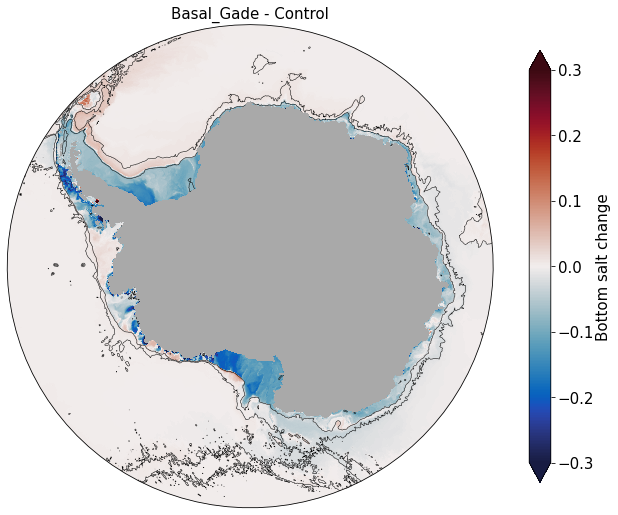

In [13]:
scale_max = .3

fig  = plt.figure(1, figsize = (25,12))
norm = col.Normalize(vmin=-scale_max,vmax=scale_max)

# Tfreezing_min_calv_2 anomaly
# setup stereo projection:
#ax = fig.add_axes([0.0, 0.0, 0.27, 1],projection=ccrs.SouthPolarStereo())
#theta = np.linspace(0, 2*np.pi, 100)
#center, radius = [0.5, 0.5], 0.5
#verts = np.vstack([np.sin(theta), np.cos(theta)]).T
#circle = mpath.Path(verts * radius + center)
#ax.set_boundary(circle, transform=ax.transAxes)
## plot:
#vmin,vmax,contourstep=34.2,35.2,0.05
##nb_contours = np.ceil((vmax-vmin)/contourstep)
#nb_contours = 20
##contours = np.arange(vmin,vmax+contourstep,contourstep)
#contours = [round(x , 4) for x in np.linspace(vmin,vmax,int(nb_contours+1))]
#cf = ax.pcolormesh(bottom_salt_con.xt_ocean, bottom_salt_con.yt_ocean, bottom_salt_Tfreezing_min_calv_2-bottom_salt_con, 
#                   norm=norm,cmap = cmocean.balance, transform = ccrs.PlateCarree())
#ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
#plt.title('Basal_Heat_Balance - Control',fontsize=fontsize)
#ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',
#             zorder=2,transform = ccrs.PlateCarree())
#ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())

# Tfreezing_min_calv_2_gade anomaly
# setup stereo projection:
ax = fig.add_axes([0, 0.0, 0.27, 1],projection=ccrs.SouthPolarStereo())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
# plot:
vmin,vmax,contourstep=34.2,35.2,0.05
#nb_contours = np.ceil((vmax-vmin)/contourstep)
nb_contours = 20
#contours = np.arange(vmin,vmax+contourstep,contourstep)
contours = [round(x , 4) for x in np.linspace(vmin,vmax,int(nb_contours+1))]
cf = ax.pcolormesh(bottom_salt_con.xt_ocean, bottom_salt_con.yt_ocean, bottom_salt_Tfreezing_min_calv_2_gade-bottom_salt_con, 
                   norm=norm,cmap = cmocean.balance, transform = ccrs.PlateCarree())
ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
plt.title('Basal_Gade - Control',fontsize=fontsize)
ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',
             zorder=2,transform = ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())

# colorbar:
#cbaxes = fig.add_axes([0.56, 0.25, 0.012, 0.5])
#cbar = plt.colorbar(cf, ticks=[34.3,34.5,34.7,34.9,35.1],cax = cbaxes, orientation = 'vertical',extend = 'both')
#cbar.set_label(r'Bottom salt change',fontsize=fontsize,labelpad=2)
#cbar.ax.tick_params(labelsize=fontsize)

# Difference
#ax = fig.add_axes([0.62, 0.0, 0.27, 1],projection=ccrs.SouthPolarStereo())
#theta = np.linspace(0, 2*np.pi, 100)
#center, radius = [0.5, 0.5], 0.5
#verts = np.vstack([np.sin(theta), np.cos(theta)]).T
#circle = mpath.Path(verts * radius + center)
#ax.set_boundary(circle, transform=ax.transAxes)
## plot:
#cf = ax.pcolormesh(bottom_salt_con.xt_ocean, bottom_salt_con.yt_ocean, bottom_salt_Tfreezing_min_calv_2_gade-bottom_salt_Tfreezing_min_calv_2, norm = norm, 
#                   cmap = cmocean.balance, transform = ccrs.PlateCarree())
#ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
#plt.title('Basal_Gade - Basal_Heat_Balance',fontsize=fontsize)
#ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',
#             zorder=2,transform = ccrs.PlateCarree())
#ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())

# colorbar:
cbaxes = fig.add_axes([0.29, 0.25, 0.012, 0.5])
cbar = plt.colorbar(cf, cax = cbaxes, orientation = 'vertical',extend = 'both')
cbar.set_label(r'Bottom salt change',fontsize=fontsize,labelpad=2)
cbar.ax.tick_params(labelsize=fontsize)

In [11]:
#Age

In [20]:
start_time='2163-10-01'
end_time='2166-01-01'

age_con = cc.querying.getvar(control, 'age_global', master_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
age_con = age_con.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
age_con = age_con.mean('time')

age_Tfreezing_min_calv_2_gade = cc.querying.getvar(Tfreezing_min_calv_2_gade, 'age_global', basal_melt_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
age_Tfreezing_min_calv_2_gade = age_Tfreezing_min_calv_2_gade.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
age_Tfreezing_min_calv_2_gade = age_Tfreezing_min_calv_2_gade.mean('time')

#age_Tfreezing_min_calv_2 = cc.querying.getvar(Tfreezing_min_calv_2, 'age_global', basal_melt_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
#age_Tfreezing_min_calv_2 = age_Tfreezing_min_calv_2.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
#age_Tfreezing_min_calv_2 = age_Tfreezing_min_calv_2.mean('time')

Exception during reset or similar
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/sqlalchemy/pool/base.py", line 697, in _finalize_fairy
    fairy._reset(pool)
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/sqlalchemy/pool/base.py", line 893, in _reset
    pool._dialect.do_rollback(self)
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/sqlalchemy/engine/default.py", line 558, in do_rollback
    dbapi_connection.rollback()
sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 22507977946944 and this is thread id 22503041505024.
Exception closing connection <sqlite3.Connection object at 0x1477de24be40>
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/sqlalchemy/pool/b

In [21]:
# select out bottom values:

depth_array = age_con * 0 + age_con.st_ocean
max_depth = depth_array.max(dim = 'st_ocean', skipna= True)

bottom_age_con = age_con.where(depth_array.st_ocean >= max_depth)
bottom_age_con = bottom_age_con.sum(dim = 'st_ocean')
bottom_age_con = bottom_age_con.load()

bottom_age_Tfreezing_min_calv_2_gade = age_Tfreezing_min_calv_2_gade.where(depth_array.st_ocean >= max_depth)
bottom_age_Tfreezing_min_calv_2_gade = bottom_age_Tfreezing_min_calv_2_gade.sum(dim = 'st_ocean')
bottom_age_Tfreezing_min_calv_2_gade = bottom_age_Tfreezing_min_calv_2_gade.load()

#bottom_age_Tfreezing_min_calv_2 = age_Tfreezing_min_calv_2.where(depth_array.st_ocean >= max_depth)
#bottom_age_Tfreezing_min_calv_2 = bottom_age_Tfreezing_min_calv_2.sum(dim = 'st_ocean')
#bottom_age_Tfreezing_min_calv_2 = bottom_age_Tfreezing_min_calv_2.load()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice 

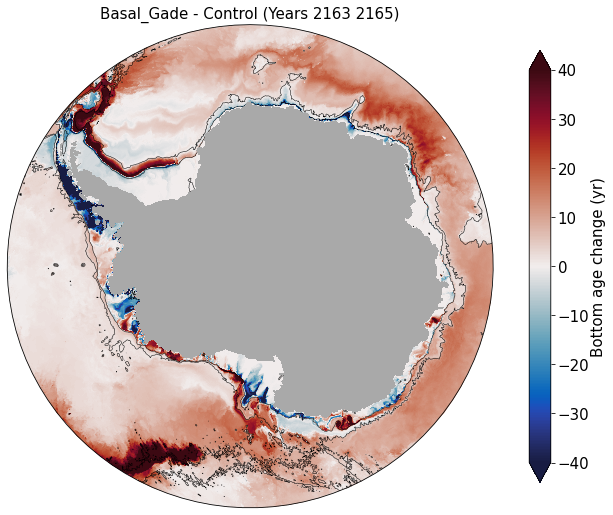

In [23]:
scale_max = 40

fig  = plt.figure(1, figsize = (25,12))
norm = col.Normalize(vmin=-scale_max,vmax=scale_max)
norm2 = col.Normalize(vmin=-2.4,vmax=1.5)

# Gade
# setup stereo projection:
#ax = fig.add_axes([0.0, 0.0, 0.27, 1],projection=ccrs.SouthPolarStereo())
#theta = np.linspace(0, 2*np.pi, 100)
#center, radius = [0.5, 0.5], 0.5
#verts = np.vstack([np.sin(theta), np.cos(theta)]).T
#circle = mpath.Path(verts * radius + center)
#ax.set_boundary(circle, transform=ax.transAxes)
## plot:
#vmin,vmax,contourstep=-2.4,1.7,0.2
##nb_contours = np.ceil((vmax-vmin)/contourstep)
#nb_contours = 20
##contours = np.arange(vmin,vmax+contourstep,contourstep)
#contours = [round(x , 4) for x in np.linspace(vmin,vmax,int(nb_contours+1))]
#cf1 = ax.pcolormesh(bottom_age_con.xt_ocean, bottom_age_con.yt_ocean, bottom_age_Tfreezing_min_calv_2 - bottom_age_con,
#                   norm=norm,cmap = cmocean.balance, transform = ccrs.PlateCarree())
#ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
#plt.title('Basal_Heat_Balance - Control',fontsize=fontsize)
#ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',
#             zorder=2,transform = ccrs.PlateCarree())
#ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())

# Anomaly Tfreezing_min_calv_2
# setup stereo projection:
ax = fig.add_axes([0, 0.0, 0.27, 1],projection=ccrs.SouthPolarStereo())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
# plot:
vmin,vmax,contourstep=-2.4,1.7,0.2
#nb_contours = np.ceil((vmax-vmin)/contourstep)
nb_contours = 20
#contours = np.arange(vmin,vmax+contourstep,contourstep)
contours = [round(x , 4) for x in np.linspace(vmin,vmax,int(nb_contours+1))]
cf1 = ax.pcolormesh(bottom_age_con.xt_ocean, bottom_age_con.yt_ocean, bottom_age_Tfreezing_min_calv_2_gade - bottom_age_con,
                   norm=norm,cmap = cmocean.balance, transform = ccrs.PlateCarree())
ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
plt.title('Basal_Gade - Control (Years 2163 2165)',fontsize=fontsize)
ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',
             zorder=2,transform = ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())

# colorbar:
#cbaxes = fig.add_axes([0.56, 0.25, 0.012, 0.5])
#cbar = plt.colorbar(cf1, ticks=[-2,-1,0,1],cax = cbaxes, orientation = 'vertical',extend = 'both')
#cbar.set_label(r'Basal_heat_balance - Control',fontsize=fontsize,labelpad=2)
#cbar.ax.tick_params(labelsize=fontsize)

# Anomaly Gade
#ax = fig.add_axes([0.62, 0.0, 0.27, 1],projection=ccrs.SouthPolarStereo())
#theta = np.linspace(0, 2*np.pi, 100)
#center, radius = [0.5, 0.5], 0.5
#verts = np.vstack([np.sin(theta), np.cos(theta)]).T
#circle = mpath.Path(verts * radius + center)
#ax.set_boundary(circle, transform=ax.transAxes)
## plot:
#cf = ax.pcolormesh(bottom_age_con.xt_ocean, bottom_age_con.yt_ocean, bottom_age_Tfreezing_min_calv_2_gade-bottom_age_Tfreezing_min_calv_2,
#                    norm=norm,cmap = cmocean.balance, transform = ccrs.PlateCarree())
#ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
#plt.title('Basal_Gade - Basal_Heat_Balance',fontsize=fontsize)
#ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',
#             zorder=2,transform = ccrs.PlateCarree())
#ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())

# colorbar:
cbaxes = fig.add_axes([0.29, 0.25, 0.012, 0.5])
cbar = plt.colorbar(cf1, cax = cbaxes, orientation = 'vertical',extend = 'both')
cbar.set_label(r'Bottom age change (yr)',fontsize=fontsize,labelpad=2)
cbar.ax.tick_params(labelsize=fontsize)

In [11]:
# Surface

In [14]:
start_time='2169-01-01'
end_time='2170-01-01'

#Import surface_temp
surface_temp_con = cc.querying.getvar(control, 'surface_temp', master_session, frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
surface_temp_con = surface_temp_con.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
surface_temp_con_sum = surface_temp_con.mean('yt_ocean').mean('xt_ocean').load()
surface_temp_con_ave = surface_temp_con.mean('time')

#surface_temp_Tfreezing_min_calv_2 = cc.querying.getvar(Tfreezing_min_calv_2, 'surface_temp', basal_melt_session, frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
#surface_temp_Tfreezing_min_calv_2 = surface_temp_Tfreezing_min_calv_2.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
#surface_temp_Tfreezing_min_calv_2_sum = surface_temp_Tfreezing_min_calv_2.sum('yt_ocean').sum('xt_ocean').load()
#surface_temp_Tfreezing_min_calv_2_ave = surface_temp_Tfreezing_min_calv_2.mean('time')

surface_temp_Tfreezing_min_calv_2_gade = cc.querying.getvar(Tfreezing_min_calv_2_gade, 'surface_temp', basal_melt_session, frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
surface_temp_Tfreezing_min_calv_2_gade = surface_temp_Tfreezing_min_calv_2_gade.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
surface_temp_Tfreezing_min_calv_2_gade_sum = surface_temp_Tfreezing_min_calv_2_gade.mean('yt_ocean').mean('xt_ocean').load()
surface_temp_Tfreezing_min_calv_2_gade_ave = surface_temp_Tfreezing_min_calv_2_gade.mean('time')

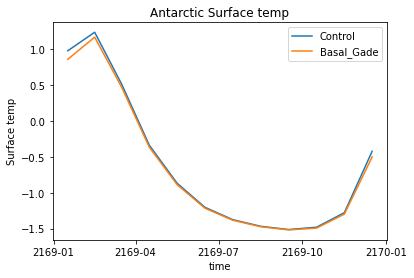

In [15]:
surface_temp_con_sum.plot(label='Control')
#surface_temp_Tfreezing_min_calv_2_sum.plot(label='Tfreezing_min_calv_2')
surface_temp_Tfreezing_min_calv_2_gade_sum.plot(label='Basal_Gade')

plt.title('Antarctic Surface temp')
plt.ylabel('Surface temp')
plt.legend();

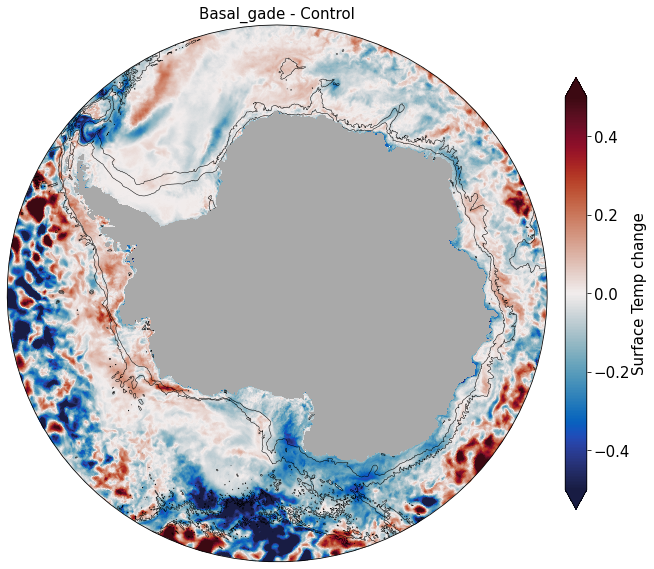

In [16]:
scale_max = .5

fig  = plt.figure(1, figsize = (25,12))
norm = col.Normalize(vmin=-scale_max,vmax=scale_max)

# Tfreezing_min
ax = fig.add_axes([0, 0.0, 0.3, 1],projection=ccrs.SouthPolarStereo())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
# plot:
cf = ax.pcolormesh(surface_temp_con_ave.xt_ocean, surface_temp_con_ave.yt_ocean, surface_temp_Tfreezing_min_calv_2_gade_ave-surface_temp_con_ave, norm = norm, 
                   cmap = cmocean.balance, transform = ccrs.PlateCarree())
ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
plt.title('Basal_gade - Control',fontsize=fontsize)
ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',
             zorder=2,transform = ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())

# colorbar:
cbaxes = fig.add_axes([0.31, 0.25, 0.012, 0.5])
cbar = plt.colorbar(cf, cax = cbaxes, orientation = 'vertical',extend = 'both')
cbar.set_label(r'Surface Temp change',fontsize=fontsize,labelpad=2)
cbar.ax.tick_params(labelsize=fontsize)


In [17]:
start_time='2169-01-01'
end_time='2170-01-01'

#Import surface_salt
surface_salt_con = cc.querying.getvar(control, 'surface_salt', master_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
surface_salt_con = surface_salt_con.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
surface_salt_con_sum = surface_salt_con.sum('yt_ocean').sum('xt_ocean').load()
surface_salt_con_ave = surface_salt_con.mean('time')

surface_salt_Tfreezing_min_calv_2_gade = cc.querying.getvar(Tfreezing_min_calv_2_gade, 'surface_salt', basal_melt_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
surface_salt_Tfreezing_min_calv_2_gade = surface_salt_Tfreezing_min_calv_2_gade.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
surface_salt_Tfreezing_min_calv_2_gade_sum = surface_salt_Tfreezing_min_calv_2_gade.sum('yt_ocean').sum('xt_ocean').load()
surface_salt_Tfreezing_min_calv_2_gade_ave = surface_salt_Tfreezing_min_calv_2_gade.mean('time')

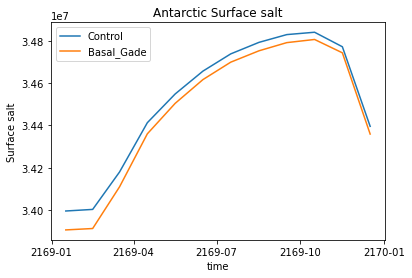

In [18]:
surface_salt_con_sum.plot(label='Control')
surface_salt_Tfreezing_min_calv_2_gade_sum.plot(label='Basal_Gade')
plt.title('Antarctic Surface salt')
plt.ylabel('Surface salt')
plt.legend();

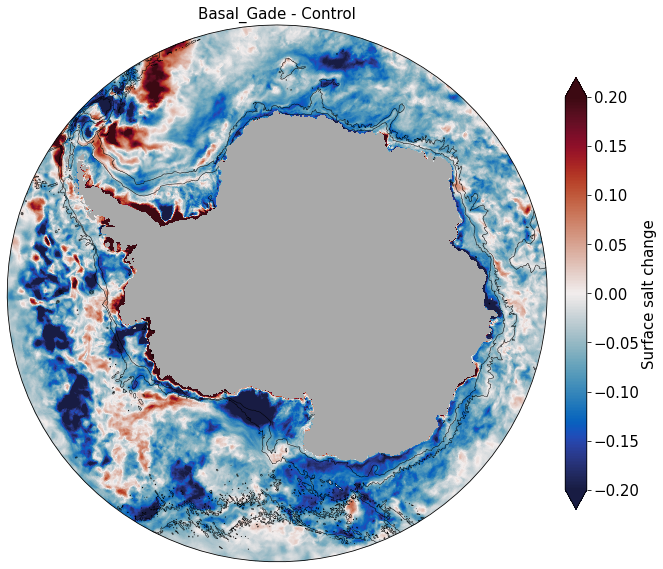

In [19]:
scale_max = .2

fig  = plt.figure(1, figsize = (25,12))
norm = col.Normalize(vmin=-scale_max,vmax=scale_max)

# Tfreezing_min
ax = fig.add_axes([0.62, 0.0, 0.3, 1],projection=ccrs.SouthPolarStereo())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
# plot:
cf = ax.pcolormesh(surface_salt_con_ave.xt_ocean, surface_salt_con_ave.yt_ocean, surface_salt_Tfreezing_min_calv_2_gade_ave-surface_salt_con_ave, norm = norm, 
                   cmap = cmocean.balance, transform = ccrs.PlateCarree())
ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
plt.title('Basal_Gade - Control',fontsize=fontsize)
ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',
             zorder=2,transform = ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())

# colorbar:
cbaxes = fig.add_axes([0.93, 0.25, 0.012, 0.5])
cbar = plt.colorbar(cf, cax = cbaxes, orientation = 'vertical',extend = 'both')
cbar.set_label(r'Surface salt change',fontsize=fontsize,labelpad=2)
cbar.ax.tick_params(labelsize=fontsize)

In [7]:
#Surface Age

In [20]:
start_time='2169-01-01'
end_time='2170-01-01'

age_con = cc.querying.getvar(control, 'age_global', master_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
age_con = age_con.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice).load()

age_Tfreezing_min_calv_2_gade = cc.querying.getvar(Tfreezing_min_calv_2_gade, 'age_global', basal_melt_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
age_Tfreezing_min_calv_2_gade = age_Tfreezing_min_calv_2_gade.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice).load()

In [27]:
#diff_age_Tfreezing_min_calv_2_gade = age_Tfreezing_min_calv_2_gade[:,18:20,:,:] - age_con[:,18:20,:,:]
#avek_diff_age_Tfreezing_min_calv_2_gade = diff_age_Tfreezing_min_calv_2_gade.mean('st_ocean')

diff_age_Tfreezing_min_calv_2_gade = age_Tfreezing_min_calv_2_gade[:,1,:,:] - age_con[:,1,:,:]
avek_diff_age_Tfreezing_min_calv_2_gade = diff_age_Tfreezing_min_calv_2_gade
avet_avek_diff_age_Tfreezing_min_calv_2_gade = avek_diff_age_Tfreezing_min_calv_2_gade.mean('time')

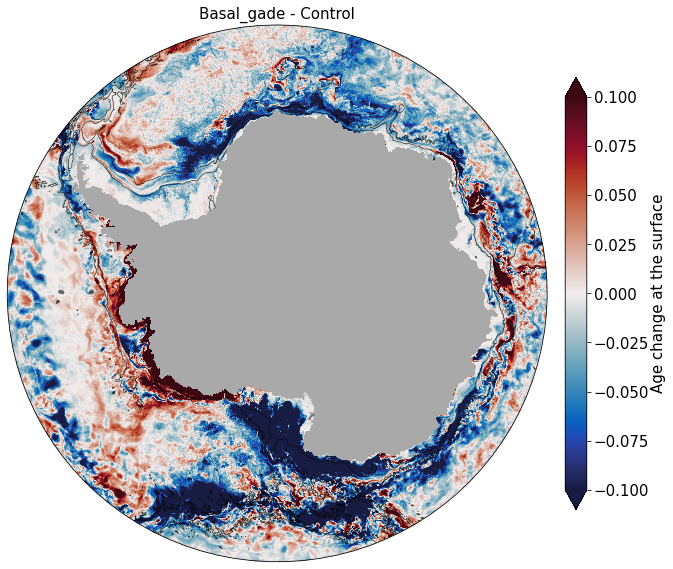

In [30]:
scale_max = 0.1

fig  = plt.figure(1, figsize = (25,12))
norm = col.Normalize(vmin=-scale_max,vmax=scale_max)

# Tfreezing_min
ax = fig.add_axes([0.62, 0.0, 0.3, 1],projection=ccrs.SouthPolarStereo())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
# plot:
cf = ax.pcolormesh(avet_avek_diff_age_Tfreezing_min_calv_2_gade.xt_ocean, avet_avek_diff_age_Tfreezing_min_calv_2_gade.yt_ocean, avet_avek_diff_age_Tfreezing_min_calv_2_gade, norm = norm, 
                   cmap = cmocean.balance, transform = ccrs.PlateCarree())
ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
plt.title('Basal_gade - Control',fontsize=fontsize)
ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',
             zorder=2,transform = ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())

# colorbar:
cbaxes = fig.add_axes([0.93, 0.25, 0.012, 0.5])
cbar = plt.colorbar(cf, cax = cbaxes, orientation = 'vertical',extend = 'both')
cbar.set_label(r'Age change at the surface',fontsize=fontsize,labelpad=2)
cbar.ax.tick_params(labelsize=fontsize)

In [6]:
#Other stuff

In [7]:
river_con = cc.querying.getvar(control, 'river', master_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
river_con = river_con.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
river_con = river_con.sum('yt_ocean').sum('xt_ocean').load()

runoff_con = cc.querying.getvar(control, 'runoff', master_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
runoff_con = runoff_con.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
runoff_con = runoff_con.sum('yt_ocean').sum('xt_ocean').load()

In [14]:
river_calving = cc.querying.getvar(calving, 'river', basal_melt_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
river_calving = river_calving.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
river_calving = river_calving.sum('yt_ocean').sum('xt_ocean').load()

runoff_calving = cc.querying.getvar(calving, 'runoff', basal_melt_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
runoff_calving = runoff_calving.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
runoff_calving = runoff_calving.sum('yt_ocean').sum('xt_ocean').load()

In [15]:
river_sbc = cc.querying.getvar(calving_sbc, 'river', basal_melt_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
river_sbc = river_sbc.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
river_sbc = river_sbc.sum('yt_ocean').sum('xt_ocean').load()

runoff_sbc = cc.querying.getvar(calving_sbc, 'runoff', basal_melt_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
runoff_sbc = runoff_sbc.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
runoff_sbc = runoff_sbc.sum('yt_ocean').sum('xt_ocean').load()

#Import basal melt
basal_sbc = cc.querying.getvar(calving_sbc, 'basal_fwflx', basal_melt_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
basal_sbc = basal_sbc.sel(time=slice(start_time,end_time))
basal_sbc = basal_sbc[:,:,:,:].sum('yt_ocean').sum('xt_ocean').sum('st_ocean').load()

In [10]:
river_Tfreezing_min_calv = cc.querying.getvar(Tfreezing_min_calv, 'river', basal_melt_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
river_Tfreezing_min_calv = river_Tfreezing_min_calv.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
river_Tfreezing_min_calv = river_Tfreezing_min_calv.sum('yt_ocean').sum('xt_ocean').load()

runoff_Tfreezing_min_calv = cc.querying.getvar(Tfreezing_min_calv, 'runoff', basal_melt_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
runoff_Tfreezing_min_calv = runoff_Tfreezing_min_calv.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
runoff_Tfreezing_min_calv = runoff_Tfreezing_min_calv.sum('yt_ocean').sum('xt_ocean').load()

#Import basal melt
basal_Tfreezing_min_calv = cc.querying.getvar(Tfreezing_min_calv, 'basal_fwflx', basal_melt_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
basal_Tfreezing_min_calv = basal_Tfreezing_min_calv.sel(time=slice(start_time,end_time))
basal_Tfreezing_min_calv = basal_Tfreezing_min_calv[:,:,:,:].sum('yt_ocean').sum('xt_ocean').sum('st_ocean').load()

In [ ]:
#Calculate ratios

In [31]:
river_con = cc.querying.getvar(control, 'river', master_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
river_con = river_con.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
river_con = river_con.sum('yt_ocean').load()

runoff_con = cc.querying.getvar(control, 'runoff', master_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
runoff_con = runoff_con.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
runoff_con = runoff_con.sum('yt_ocean').load()

river_Tfreezing_min_calv = cc.querying.getvar(Tfreezing_min_calv, 'river', basal_melt_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
river_Tfreezing_min_calv = river_Tfreezing_min_calv.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
river_Tfreezing_min_calv = river_Tfreezing_min_calv.sum('yt_ocean').load()

runoff_Tfreezing_min_calv = cc.querying.getvar(Tfreezing_min_calv, 'runoff', basal_melt_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
runoff_Tfreezing_min_calv = runoff_Tfreezing_min_calv.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
runoff_Tfreezing_min_calv = runoff_Tfreezing_min_calv.sum('yt_ocean').load()

#Import basal melt
basal_Tfreezing_min_calv = cc.querying.getvar(Tfreezing_min_calv, 'basal_fwflx', basal_melt_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
basal_Tfreezing_min_calv = basal_Tfreezing_min_calv.sel(time=slice(start_time,end_time))
basal_Tfreezing_min_calv = basal_Tfreezing_min_calv[:,:,:,:].sum('yt_ocean').sum('st_ocean').load()

In [15]:
calving_Tfreezing_min_calv = river_Tfreezing_min_calv - runoff_Tfreezing_min_calv
tot_river_Tfreezing_min_calv = calving_Tfreezing_min_calv + basal_Tfreezing_min_calv

In [21]:
ratio = runoff_Tfreezing_min_calv[0,:] * 0
for xx in range(runoff_Tfreezing_min_calv.shape[1]):
    if runoff_con[0,xx] != 0:
        ratio[xx] = tot_river_Tfreezing_min_calv[0,xx] / runoff_con[0,xx]
    else:
        ratio[xx] = 0

In [ ]:
#Data comparison

In [30]:
import numpy as np
from netCDF4 import Dataset as nc

nc_calv_file = "/g/data/e14/pc5520/calving/licalvf.nc"
nc_runoff_file="/g/data/e14/pc5520/calving/RYF.runoff_all.1990_1991.nc"
ncfile_calv = nc(nc_calv_file,'r')
ncfile_runoff = nc(nc_runoff_file,'r')
calving = ncfile_calv.variables['licalvf'][0,:,:]
lon = ncfile_calv.variables['lon'][:]
friver  = ncfile_runoff.variables['friver'][0,:,:]

calving_sumy = calving[0,:]*0
friver_sumy  = friver[0,:]*0
xxx = friver[0,:]*0

In [31]:
for xx in range(friver[:,:].shape[1]):
    xxx[xx] = xx
    friver_sumy[xx] = friver[:,xx].sum()
    calving_sumy[xx] = calving[:,xx].sum()

In [65]:
calving_sumy_adj = calving_sumy * 0
friver_sumy_adj = friver_sumy * 0
lon_adj = lon * 0
calving_sumy_adj[0:280*4] = calving_sumy[80*4:]
friver_sumy_adj[0:280*4] = friver_sumy[80*4:]
calving_sumy_adj[280*4:] = calving_sumy[0:80*4]
friver_sumy_adj[280*4:] = friver_sumy[0:80*4]
for xx in range(friver[:,:].shape[1]):
    lon_adj[xx] = lon[xx] - 280

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


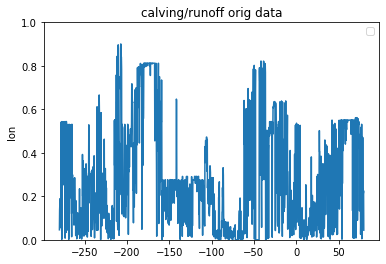

In [89]:
plt.plot(lon_adj,calving_sumy_adj/friver_sumy_adj)
plt.ylim(ymin =0,ymax=1)
plt.title('calving/runoff orig data')
plt.ylabel('lon')
plt.legend();

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


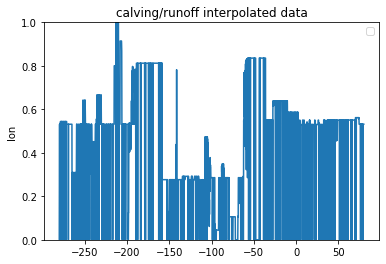

In [12]:
plt.plot(runoff_calving.xt_ocean,ratio)
plt.ylim(ymin =0,ymax=1)
plt.title('calving/runoff interpolated data')
plt.ylabel('lon')
plt.legend();

In [13]:
ratio = calving_sbc[0,:] * 0
for xx in range(calving_sbc.shape[1]):
    if calving_sbc[0,xx] != 0:
        ratio[xx] = calving_sbc[0,xx] / runoff_calving[0,xx]
    else:
        ratio[xx] = 1

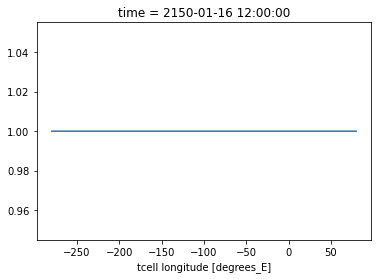

In [14]:
ratio.plot()

In [21]:
river_con[0]

<xarray.DataArray 'river' ()>
array(5.716117, dtype=float32)
Coordinates:
    time     object 2150-01-16 12:00:00

In [22]:
(tot_river_sbc/river_con[0])

<xarray.DataArray (time: 1)>
array([0.99999994], dtype=float32)
Coordinates:
  * time     (time) object 2150-01-16 12:00:00

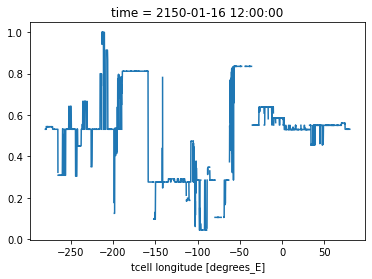

In [39]:
(calving_Tfreezing_min_calv[0]/runoff_con[0]).plot()


In [40]:
runoff_con[0].sum()

<xarray.DataArray 'runoff' ()>
array(5.7161164, dtype=float32)
Coordinates:
    time     object 2150-01-16 12:00:00

In [49]:
tot_river_Tfreezing_min_calv[4].sum()

<xarray.DataArray ()>
array(5.716117, dtype=float32)
Coordinates:
    time     object 2150-05-16 12:00:00

In [ ]:
river_con = cc.querying.getvar(control, 'river', master_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
river_con = river_con.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
river_con = river_con.sum('yt_ocean').load()

runoff_con = cc.querying.getvar(control, 'runoff', master_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
runoff_con = runoff_con.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
runoff_con = runoff_con.sum('yt_ocean').load()

river_Tfreezing_min_calv = cc.querying.getvar(Tfreezing_min_calv_2, 'river', basal_melt_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
river_Tfreezing_min_calv = river_Tfreezing_min_calv.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
river_Tfreezing_min_calv = river_Tfreezing_min_calv.sum('yt_ocean').load()

runoff_Tfreezing_min_calv = cc.querying.getvar(Tfreezing_min_calv, 'runoff', basal_melt_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
runoff_Tfreezing_min_calv = runoff_Tfreezing_min_calv.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
runoff_Tfreezing_min_calv = runoff_Tfreezing_min_calv.sum('yt_ocean').load()

#Import basal melt
basal_Tfreezing_min_calv = cc.querying.getvar(Tfreezing_min_calv, 'basal_fwflx', basal_melt_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
basal_Tfreezing_min_calv = basal_Tfreezing_min_calv.sel(time=slice(start_time,end_time))
basal_Tfreezing_min_calv = basal_Tfreezing_min_calv[:,:,:,:].sum('yt_ocean').sum('st_ocean').load()

calving_Tfreezing_min_calv = river_Tfreezing_min_calv - runoff_Tfreezing_min_calv
tot_river_Tfreezing_min_calv = calving_Tfreezing_min_calv + basal_Tfreezing_min_calv

In [6]:
#Iceberg fluxes comparison

In [26]:
river_con = cc.querying.getvar(control, 'river', master_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
river_con = river_con.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
river_con_x = river_con.sum('yt_ocean').load()
river_con_tot = river_con.sum('yt_ocean').sum('xt_ocean').load()

In [61]:
river_sbc = cc.querying.getvar(calving_sbc, 'river', basal_melt_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
river_sbc = river_sbc.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
river_sbc = river_sbc.sum('yt_ocean').sum('xt_ocean').load()

runoff_sbc = cc.querying.getvar(calving_sbc, 'runoff', basal_melt_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
runoff_sbc = runoff_sbc.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
runoff_sbc = runoff_sbc.sum('yt_ocean').sum('xt_ocean').load()

calving_sbc = river_sbc - runoff_sbc

In [ ]:
#Iceberg climatology

In [33]:
import numpy as np
from netCDF4 import Dataset as nc

nc_icb_file = "/home/552/pc5520/forcing_files/Iceberg_Climatology_Merino.nc"
ncfile_icb = nc(nc_icb_file,'r')
icbflux = ncfile_icb.variables['Icb_flux'][:,:,:]
lon_icb = ncfile_icb.variables['longitude'][:,:]
lat_icb = ncfile_icb.variables['latitude'][:,:]
#ncfile_icb.close()

In [ ]:
calving_sumy_adj = calving_sumy * 0
lon_adj = lon * 0
calving_sumy_adj[0:429] = calving_sumy[80*4:]
calving_sumy_adj[429:] = calving_sumy[0:80*4]
for xx in range(friver[:,:].shape[1]):
    lon_adj[xx] = lon[xx] - 280

In [44]:
icbflux_x = icbflux[:,0,:] * 0
for tt in range(icbflux.shape[0]):
    for xx in range(icbflux.shape[2]):
        icbflux_x[tt,xx] = icbflux[tt,:,xx].sum()


In [60]:
lon_icb[0,430]

-179.75

In [51]:
icbflux_x[0,0]

masked_array(data=[0.        , 0.0007348 , 0.0007387 , ..., 0.00083828,
                   0.00081082, 0.        ],
             mask=False,
       fill_value=1e+20,
            dtype=float32)

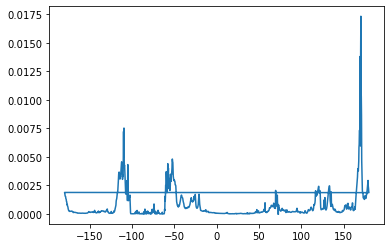

In [45]:
plt.plot(lon_icb[0],icbflux_x[0])

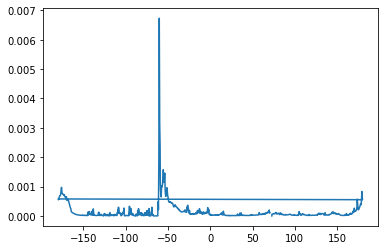

In [53]:
plt.plot(lon_icb[0],icbflux_x[6])

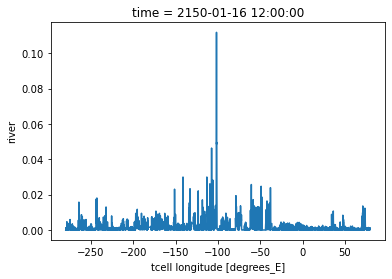

In [37]:
river_con_x[0].plot()

In [40]:
icbflux[6,:,:].sum()/river_con_tot[6]

<xarray.DataArray 'river' ()>
array(0.03587823, dtype=float32)
Coordinates:
    time     object 2150-07-16 12:00:00

In [66]:
icbflux[6,:,:].sum()/calving_sbc[0]

<xarray.DataArray ()>
array(0.07307607, dtype=float32)
Coordinates:
    time     object 2150-01-16 12:00:00

In [11]:
lat_slice  = slice(-80,-59)

river_Tfreezing_min_calv = cc.querying.getvar(Tfreezing_min_calv, 'river', basal_melt_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
river_Tfreezing_min_calv = river_Tfreezing_min_calv.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
river_Tfreezing_min_calv = river_Tfreezing_min_calv.sum('yt_ocean').load()

runoff_Tfreezing_min_calv = cc.querying.getvar(Tfreezing_min_calv, 'runoff', basal_melt_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
runoff_Tfreezing_min_calv = runoff_Tfreezing_min_calv.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
runoff_Tfreezing_min_calv = runoff_Tfreezing_min_calv.sum('yt_ocean').load()

#Import basal melt
basal_Tfreezing_min_calv = cc.querying.getvar(Tfreezing_min_calv, 'basal_fwflx', basal_melt_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
basal_Tfreezing_min_calv = basal_Tfreezing_min_calv.sel(time=slice(start_time,end_time))
basal_Tfreezing_min_calv = basal_Tfreezing_min_calv[:,:,:,:].sum('yt_ocean').sum('st_ocean').load()

In [12]:
calving_Tfreezing_min_calv = river_Tfreezing_min_calv - runoff_Tfreezing_min_calv
tot_river_Tfreezing_min_calv = calving_Tfreezing_min_calv + basal_Tfreezing_min_calv

In [10]:
calving_Tfreezing_min_calv[0].sum()

<xarray.DataArray ()>
array(2.8064477, dtype=float32)
Coordinates:
    time     object 2150-01-16 12:00:00

In [13]:
calving_Tfreezing_min_calv[0].sum()

<xarray.DataArray ()>
array(2.8064477, dtype=float32)
Coordinates:
    time     object 2150-01-16 12:00:00

In [9]:
start_time='2150-01-01'
end_time='2152-01-01'

lat_slice  = slice(-80,-59)

river_con = cc.querying.getvar(control, 'river', master_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
river_con = river_con.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
river_con = river_con.sum('yt_ocean').load()

runoff_con = cc.querying.getvar(control, 'runoff', master_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
runoff_con = runoff_con.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
runoff_con = runoff_con.sum('yt_ocean').load()

river_Tfreezing_min_calv_2 = cc.querying.getvar(Tfreezing_min_calv_2, 'river', basal_melt_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
river_Tfreezing_min_calv_2 = river_Tfreezing_min_calv_2.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
river_Tfreezing_min_calv_2 = river_Tfreezing_min_calv_2.sum('yt_ocean').load()

runoff_Tfreezing_min_calv_2 = cc.querying.getvar(Tfreezing_min_calv_2, 'runoff', basal_melt_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
runoff_Tfreezing_min_calv_2 = runoff_Tfreezing_min_calv_2.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
runoff_Tfreezing_min_calv_2 = runoff_Tfreezing_min_calv_2.sum('yt_ocean').load()

#Import basal melt
basal_Tfreezing_min_calv_2 = cc.querying.getvar(Tfreezing_min_calv_2, 'basal_fwflx', basal_melt_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
basal_Tfreezing_min_calv_2 = basal_Tfreezing_min_calv_2.sel(time=slice(start_time,end_time))
basal_Tfreezing_min_calv_2 = basal_Tfreezing_min_calv_2[:,:,:,:].sum('yt_ocean').sum('st_ocean').load()

calving_Tfreezing_min_calv_2 = river_Tfreezing_min_calv_2 - runoff_Tfreezing_min_calv_2
tot_river_Tfreezing_min_calv_2 = calving_Tfreezing_min_calv_2 + basal_Tfreezing_min_calv_2

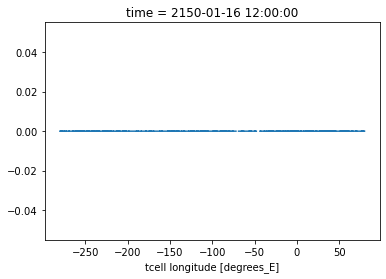

In [10]:
(calving_Tfreezing_min_calv_2[0]/runoff_con[0]).plot()

In [18]:
river_Tfreezing_min_calv_2 = cc.querying.getvar(Tfreezing_min_calv_2, 'river', basal_melt_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
river_Tfreezing_min_calv_2 = river_Tfreezing_min_calv_2.sel(time=slice(start_time,end_time))
river_Tfreezing_min_calv_2 = river_Tfreezing_min_calv_2.load()

runoff_Tfreezing_min_calv_2 = cc.querying.getvar(Tfreezing_min_calv_2, 'runoff', basal_melt_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
runoff_Tfreezing_min_calv_2 = runoff_Tfreezing_min_calv_2.sel(time=slice(start_time,end_time))
runoff_Tfreezing_min_calv_2 = runoff_Tfreezing_min_calv_2.load()

In [19]:
calving_Tfreezing_min_calv_2 = river_Tfreezing_min_calv_2 - runoff_Tfreezing_min_calv_2

In [20]:
calving_Tfreezing_min_calv_2[0]

<xarray.DataArray (yt_ocean: 2700, xt_ocean: 3600)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
    time      object 2150-01-16 12:00:00

In [24]:
calving_Tfreezing_min_calv_2[0].max()

<xarray.DataArray ()>
array(6.04987144e-06)
Coordinates:
    time     object 2150-01-16 12:00:00

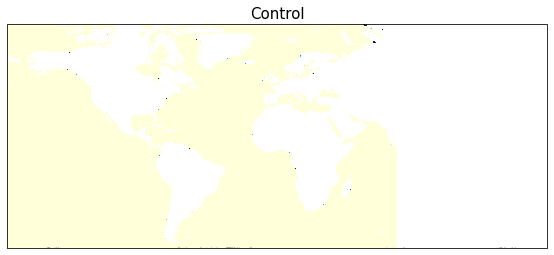

In [29]:
scale_max = .015

fig  = plt.figure(1, figsize = (25,12))
norm = col.Normalize(vmin=-scale_max,vmax=scale_max)
norm2 = col.Normalize(vmin=0,vmax=0.96)


# Tfreezing_min
# setup stereo projection:
ax = fig.add_axes([0.0, 0.0, 0.3, 1],projection=ccrs.PlateCarree())
## plot:
cf = ax.pcolormesh(calving_Tfreezing_min_calv_2.xt_ocean, calving_Tfreezing_min_calv_2.yt_ocean, calving_Tfreezing_min_calv_2[0], vmin=0,vmax=6.04987144e-07,  
                   cmap = cmocean.cm.YlGnBu, transform = ccrs.PlateCarree())
ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
plt.title('Control',fontsize=fontsize)
ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',
             zorder=2,transform = ccrs.PlateCarree())
ax.set_extent([-180, 180, 90, -59], ccrs.PlateCarree())